## Check_spinup global results
- reads in MIMICS results and checks for change in soil and veg C pool & fluxes
- data are here /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS/OUTPUT_CN/SPIN

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy 
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines

print(xr.__version__)
%matplotlib inline

0.15.0


In [2]:
import pandas.util.testing as tm
path = '/project/tss/wwieder/biogeochem_testbed_1.1/'
case = 'GRID_CN/MIMICS/OUTPUT_CN/SPIN/'
full_pathMIM = path+case+'mimics_pool_flux_*0.nc'  # read in data every 10 years
full_pathCAS = path+case+'casaclm_pool_flux_*0.nc' # casa files for vegetation results
print(full_pathMIM)

ds   = xr.open_mfdataset(full_pathMIM, decode_times=True, combine='by_coords')
dsVeg= xr.open_mfdataset(full_pathCAS, decode_times=True, combine='by_coords')

#combine relevent data from casa history files to MIMICS data
ds['cnpp'] = dsVeg['cnpp']
ds['cgpp'] = dsVeg['cgpp']

# sum soil C & N pools
ds = utils.sum_pools(ds, 'mim')

/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS/OUTPUT_CN/SPIN/mimics_pool_flux_*0.nc


/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Distributions of soilC

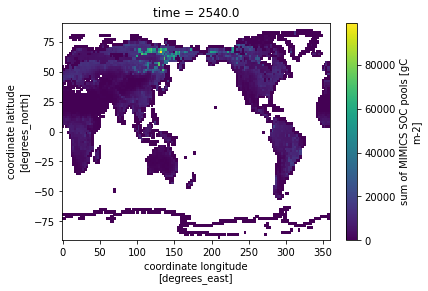

In [3]:
ds['cTOT'].isel(time=-1).plot();

### total soil C:N

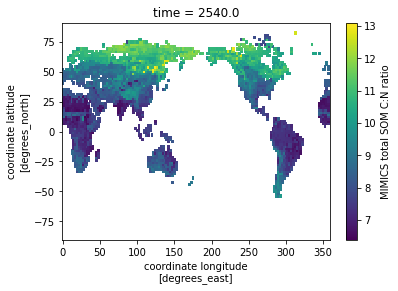

In [4]:
ds['cnTOT'].isel(time=-1).plot();

### look at NPP

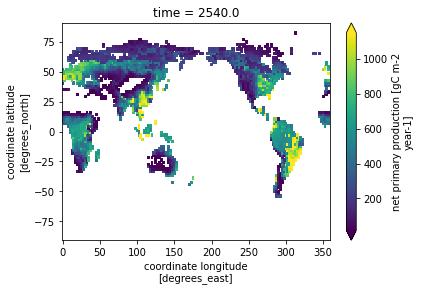

In [5]:
ds['cnpp'].where(ds.cnpp>10).isel(time=-1).plot(robust=True);

## Define function for printing global sum

In [6]:
def globalSum ( dsIn, var, area=ds.landarea.isel(time=-1) *1e6, time=1, conversion=1e-15, units=None, plot=True ):
    "Global weighted sum of fluxes & states"
    temp = dsIn[var] * area 
    temp = temp.sum(dim=('lat','lon')) * conversion
    if plot==True:
        plt.figure(figsize=[16,4]);
        for i in range(len(var)):
            plt.subplot(1, 3, (1+i))
            plt.ylabel('Global '+var[i]+' (Pg C y^-1)')
            plt.plot(temp['time'], temp[var[i]]);
    else:
        for i in range(len(var)):
            print('global '+var[i]+' '+str(np.round(temp[var[i]].isel(time=-1).values,1) )+' Pg C')

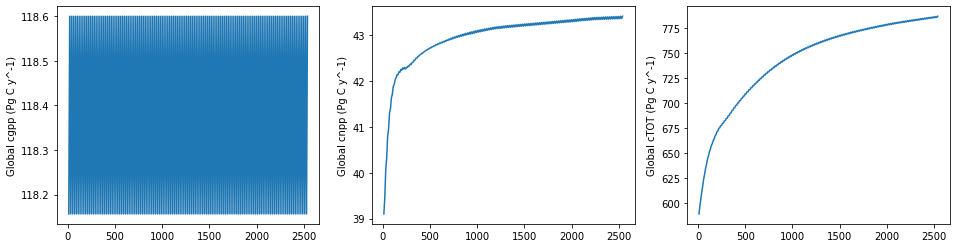

In [7]:
Cvars =['cgpp','cnpp','cTOT']
globalSum(ds,Cvars, plot=True)

In [8]:
ConlyIN = '/project/tss/wwieder/CASACLM/GRID/OUTPUT_GRID_CRU_NCEP/MIMICS_SPIN_b/'
Ccas = ConlyIN+'casaclm_pool_flux_9000_9980.nc'
Cmim = ConlyIN+'mimics_pool_flux_9000_9980.nc'

In [9]:
ds.landarea

<xarray.DataArray 'landarea' (time: 254, lat: 96, lon: 144)>
dask.array<concatenate, shape=(254, 96, 144), dtype=float32, chunksize=(1, 96, 144)>
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
  * time     (time) float64 10.0 20.0 30.0 40.0 ... 2.52e+03 2.53e+03 2.54e+03
Attributes:
    long_name:  land area, icewater set to 0.0
    units:      km^2

In [10]:
dsC     = xr.open_mfdataset(Cmim, decode_times=True,combine='by_coords')
dsCveg  = xr.open_mfdataset(Ccas, decode_times=True,combine='by_coords')
dsC['cnpp'] = dsCveg['cnpp']
dsC['cgpp'] = dsCveg['cgpp']
dsC = utils.sum_pools(dsC, mod='mim', CN='False')

In [11]:
globalSum(dsC,Cvars, plot=False)

global cgpp 118.6 Pg C
global cnpp 48.9 Pg C
global cTOT 1470.3 Pg C


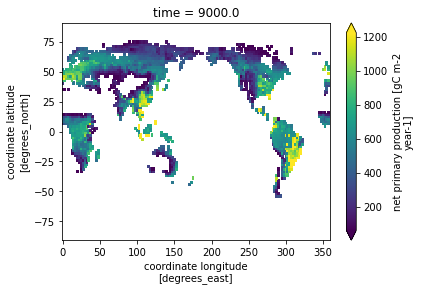

In [12]:
dsC['cnpp'].where(dsC['cnpp']>50).isel(time=0).plot(robust=True);

### difference in NPP (CN-C)
- most notably in boreal forests.
- somewhat int tropcs

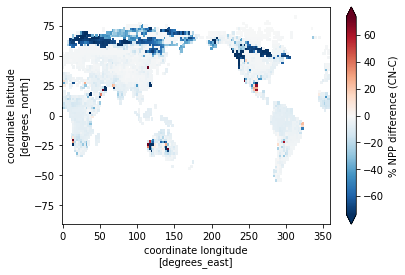

In [13]:
ds['d_cnpp'] = (ds['cnpp'].isel(time=-1) - dsC['cnpp'].isel(time=-1))/ dsC['cnpp'].isel(time=-1) * 100
ds['d_cnpp'].attrs['long_name'] = '% NPP difference (CN-C)'
ds['d_cnpp'].plot(robust=True);

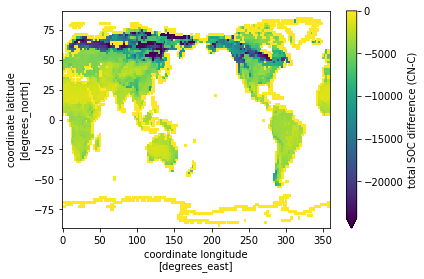

In [14]:
ds['d_cTOT'] = ds['cTOT'].isel(time=-1) - dsC['cTOT'].isel(time=-1)
ds['d_cTOT'].attrs['long_name'] = 'total SOC difference (CN-C)'
ds['d_cTOT'].plot(robust=True);

In [15]:
var  =  ['cHresp','cnpp', 'cgpp']
varLong  =  ['Rh_mim','npp', 'gpp']

# sum up fluxes
ann_flux = ds * ds.landarea *1e6
for i in range(len(var)):
    ann_flux.get(var[i]).attrs['units'] = 'gC y-1'

nan


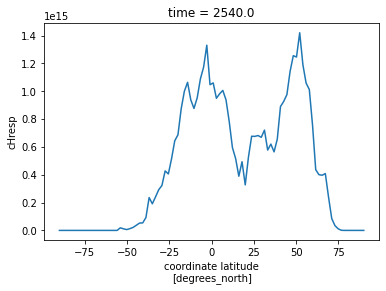

In [16]:
print(ann_flux.get(var[0]).values.sum()*1e-15) #convert gC to PgC
zon_sum = ann_flux.sum(dim='lon')
zon_sum.cHresp.isel(time=-1).plot();
#zon_sum

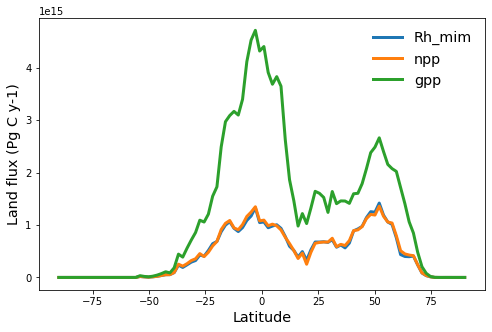

In [17]:
plt.figure(figsize=[8,5])
#plt.ylabel('Change Global Land C ('+g585y.units+')', fontsize='x-large')
for i in range(len(var)):
    plt.plot(zon_sum.lat, zon_sum.get(var[i]).isel(time=-1), lw=3)

plt.legend(labels=(varLong), frameon = False, fontsize='x-large')
plt.ylabel('Land flux (Pg C y-1)', fontsize='x-large')
plt.xlabel('Latitude', fontsize='x-large');